In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
from utils import create_translation_dic

In [8]:
def get_df(adm_year, num_sem, grad_mapper):
    all_df = []
    n_rows_dropped = 0.
    n_rows_original = 0.
    for i in tqdm(range(2007, min(adm_year + 8, 2021))):
        # Read in data
        df = pd.read_csv("data/graduation/Titulados-de-Educacion-Superior-{}/Titulados_Educacion_Superior_{}.csv".format(i,i), sep=";",
                        dtype={"MRUN": 'str' , "EDAD_ALU":'str', 'cod_carrera': 'str', 'version': 'str', 'cod_sede':'str', 
                               'dur_estudio_carr':'str', 'dur_proceso_tit':'str', 'dur_total_carr':'str' })
        # Replace empty strings with NaN
        df = df.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
        
        # Translate columns
        df.columns = map(str.upper, df.columns)
        df = df.rename(columns=grad_mapper)
        
        #Only look at students with admission year equal to adm_year
        df = df[df['Year of admission as a freshman']==adm_year]
        if num_sem != None:
            df = df[df['Total theoretical duration of the degree (in semesters)']=="{}".format(num_sem)]
        
        n_rows_dropped += len(df)
        n_rows_original += len(df)
        
        # Drop rows that have NaN in important columns
        df = df[df['Year of admission as a freshman'].notna()]
        df = df[df['Semester of admission as a freshman'].notna()]
        df = df[df['Date of the title (YYYYMMDD)'].notna()]
        df = df[df['Total theoretical duration of the degree (in semesters)'].notna()]
        
        
        df = df[relevant_keys]
        df.reset_index(inplace=True, drop=True)
        n_rows_dropped -= len(df)
        all_df.append(df)
        
    main_df = pd.concat(all_df, ignore_index=True)
    return main_df, n_rows_dropped, n_rows_original

In [9]:
def graduate_on_time(df):
    adm_sem = df['Semester of admission as a freshman'].astype("int").to_numpy()
    adm_year = df['Year of admission as a freshman'].astype("int").to_numpy()
    
    month_dic = {1:3, 2:7}
    adm_month = [*map(month_dic.get, adm_sem)]
    
    adm_dates = [datetime.date(year=adm_year[i], month=adm_month[i], day=1) for i in range(len(adm_year))]
    deg_date = df['Date of the title (YYYYMMDD)'].astype("str")
    deg_dates = [datetime.date(year=int(x[:4]), month=int(x[4:6]), day=int(x[6:])) for x in deg_date ]
    durations = np.array([round((deg_dates[i] - adm_dates[i]).days/365, 1) for i in range(len(adm_dates))])
    
    length_degree = df['Total theoretical duration of the degree (in semesters)'].astype("int").to_numpy()/2
    on_time_grad = (durations <= length_degree)
    if len(on_time_grad) > 1:
        grad_rate = sum(on_time_grad)/len(on_time_grad)
    else:
        grad_rate = 0.
    n = len(on_time_grad) 
    
    return grad_rate, n

In [10]:
years = list(range(2007, 2016))
num_sems=[None]
dic = {}
for num_sem in num_sems:
    dic[num_sem] = {"n": [], "grad_rates": [], "n_rows_dropped": [], "n_rows_original": []}
    
grad_mapper = create_translation_dic("Graduation")


for num_sem in num_sems:
    for year in years:
        df, n_rows_dropped, n_rows_original = get_df(int(year), num_sem, grad_mapper=grad_mapper)
        grad_rate, n = graduate_on_time(df)
        dic[num_sem]["n"].append(n)
        dic[num_sem]["grad_rates"].append(grad_rate)
        dic[num_sem]["n_rows_dropped"].append(n_rows_dropped)
        dic[num_sem]["n_rows_original"].append(n_rows_original)

100%|███████████████████████████████████████████| 14/14 [01:29<00:00,  6.37s/it]


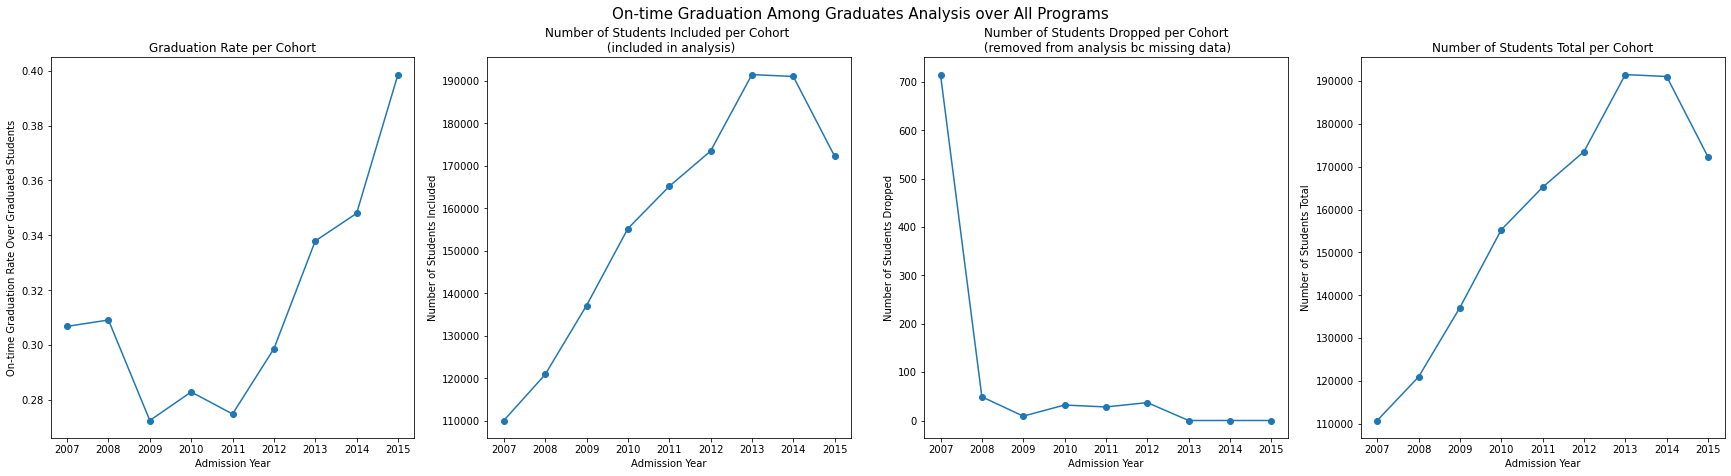

In [11]:
for num_sem in num_sems:
    fig, ax = plt.subplots(1, 4, figsize=(30, 7))
    if num_sem == None:
        name= "All Programs"
    else:
        name = "{}-Semester Programs".format(num_sem)
    plt.suptitle("On-time Graduation Among Graduates Analysis over {}".format(name), fontsize=15)
    
    ax[0].plot(years, dic[num_sem]["grad_rates"], marker="o")
    ax[0].set_ylabel("On-time Graduation Rate Over Graduated Students")
    ax[0].set_title("Graduation Rate per Cohort".format(num_sem))
    
    ax[1].plot(years, dic[num_sem]["n"], marker="o")
    ax[1].set_ylabel("Number of Students Included")
    ax[1].set_title("Number of Students Included per Cohort \n (included in analysis)")
    
    ax[2].plot(years, dic[num_sem]["n_rows_dropped"], marker="o")
    ax[2].set_ylabel("Number of Students Dropped")
    ax[2].set_title("Number of Students Dropped per Cohort\n (removed from analysis bc missing data)")
    
    ax[3].plot(years, dic[num_sem]["n_rows_original"], marker="o")
    ax[3].set_ylabel("Number of Students Total")
    ax[3].set_title("Number of Students Total per Cohort")
    
    for i in range(4):
        ax[i].set_xlabel("Admission Year")
        
    plt.savefig("figs/{}.pdf".format(name.lower()))
    plt.show()
    plt.close()